In [47]:
from SimPEG import *
import simpegDCIP as DC
from numpy.polynomial import polynomial

In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [49]:
cs = 0.5
mesh = Mesh.TensorMesh([np.ones(100)*cs, np.ones(50)*cs], "CN")
x = mesh.vectorCCx

In [50]:
actx = (x>-15.)&(x<15.)

In [98]:
order = 3
Vobs = polynomial.polyvander(x, order)
dobs = 0.05*x-4
H = np.dot(Vobs.T, Vobs)
g = np.dot(Vobs.T, dobs)
mest = np.linalg.solve(H, g)

In [99]:
dpred = Vobs.dot(mest)

In [100]:
V = polynomial.polyvander(x, order)
m1D = Mesh.TensorMesh([V.shape[1]+2])
weight = (1./(V**2).sum(axis=0))**0.5
weight = weight / weight.max()
weightmap = Maps.Weighting(m1D, weights=np.r_[1., 1., weight])
m0_poly = np.r_[np.log(1e-3), np.log(1e-3), np.r_[-3., np.zeros(V.shape[1]-1)] / weight]
mtrue_poly = np.r_[np.log(1e-3), np.log(1e0), mest / weight]

In [101]:
polymap = Maps.PolyMap(mesh, V.shape[1]-1, logSigma=True, normal='Y')
mappingfwd = polymap*weightmap
mapping = Maps.ExpMap(mesh)

In [102]:
sigma = mappingfwd*mtrue_poly

In [103]:
xr = np.linspace(-15, 15, 20)
xz_A = Utils.ndgrid(xr, np.r_[-0.25])
xz_B = Utils.ndgrid(np.ones_like(xr)*22, np.r_[-0.25])
xz_M = Utils.ndgrid(xr, np.r_[-0.25])
xz_N = Utils.ndgrid(np.ones_like(xr)*-22, np.r_[-0.25])

ntx = xz_A.shape[0]
txList = []
for i in range(ntx):
    offset = abs(xz_A[i,0]-xz_M[:,0])
    actrx = offset > 5.
    rx = DC.RxDipole(xz_M[actrx,:], xz_N[actrx,:])
    src = DC.SrcDipole([rx], xz_A[i,:], xz_B[i,:])
    txList.append(src)

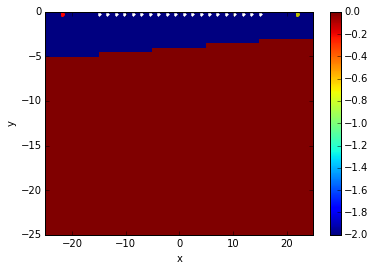

In [104]:
dat = mesh.plotImage(np.log10(sigma), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

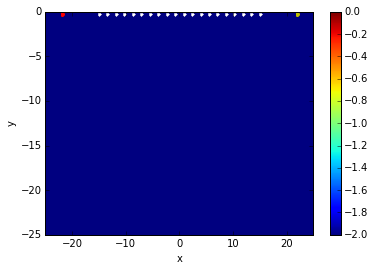

In [105]:
dat = mesh.plotImage(np.log10(mappingfwd*m0), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

In [106]:
from pymatsolver import MumpsSolver

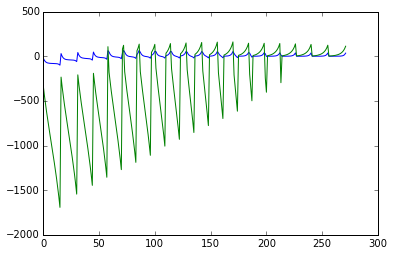

In [107]:
mtrue = np.log(sigma)
m0 = np.log(np.ones(mesh.nC)*1e-3)
survey = DC.SurveyDC(txList)
problem = DC.ProblemDC_CC(mesh, mapping = mapping)
problem.pair(survey)
problem.Solver = MumpsSolver
dtrue  = survey.dpred(mtrue)
d0  = survey.dpred(m0)
plot(dtrue)
plot(d0)

In [108]:
abs(dtrue).min()

0.004688525906217933

(array([  1.,   2.,   3.,   4.,   5.,   4.,   6.,   7.,   8.,   9.,   8.,
         10.,  17.,  17.,  18.,  33.,  41.,  30.,  32.,  17.]),
 array([-2.32896368, -2.11250236, -1.89604103, -1.67957971, -1.46311839,
        -1.24665706, -1.03019574, -0.81373442, -0.59727309, -0.38081177,
        -0.16435044,  0.05211088,  0.2685722 ,  0.48503353,  0.70149485,
         0.91795617,  1.1344175 ,  1.35087882,  1.56734014,  1.78380147,
         2.00026279]),
 <a list of 20 Patch objects>)

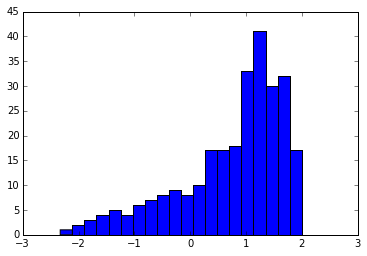

In [109]:
hist(np.log10(abs(dtrue)), bins = 20)

In [110]:
noise = 0.05*abs(dtrue)*np.random.randn(dtrue.shape[0])

In [111]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.Tikhonov(mesh)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaSched = Directives.BetaSchedule(coolingFactor=8, coolingRate=3)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.alpha_s = 1e-5
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e+00  1.40e+08  0.00e+00  1.40e+08    8.32e+06      0              
   1  1.00e+00  1.88e+07  6.18e-03  1.88e+07    1.13e+06      0              
   2  1.00e+00  2.52e+06  2.45e-02  2.52e+06    1.55e+05      0   Skip BFGS  
   3  1.25e-01  3.50e+05  5.43e-02  3.50e+05    2.18e+04      0   Skip BFGS  
   4  1.25e-01  6.62e+04  9.32e-02  6.62e+04    3.26e+03      0   Skip BFGS  
   5  1.25e-01  1.56e+04  7.26e+00  1.56e+04    4.80e+02      1   Skip BFGS  
   6  1.56e-02  4.47e+03  1.84e+01  4.47e+03    5.41e+02      1              
   7  1.56e-02  2.73e+03  4.08e+01  2.73e+03    2.91e+03      0   Skip BFGS  
   8  1

In [112]:
XC = opt.recall('xc')

In [113]:
from ipywidgets import interact, IntSlider
def viewInv(iteration):
    fig  = plt.figure(num=0,figsize = (10,5))
    ax = plt.subplot(111)
    dat = mesh.plotImage(np.log10(mapping*XC[iteration]), grid=True, ax=ax, clim=(-3, 0), gridOpts={'alpha':0.2}, pcolorOpts={'cmap':cm.RdPu})
#     ax.set_xlim(mesh.vectorNx.min(), mesh.vectorNx.max())
#     ax.set_ylim(mesh.vectorNy.min(), mesh.vectorNy.max())
    ax.plot(mesh.vectorCCx, dpred, 'r--')
    ax.plot(xz_A[:,0], xz_A[:,1], 'k.')
    ax.plot(xz_B[:,0], xz_B[:,1], 'r.')
    ax.plot(xz_N[:,0], xz_N[:,1], 'b.')    
#     plt.colorbar(dat[0], ax=ax)
#     ax.set_ylim (-15, 0.)
#     ax.set_xlim (-15, 15.)
    plt.show()
    return True

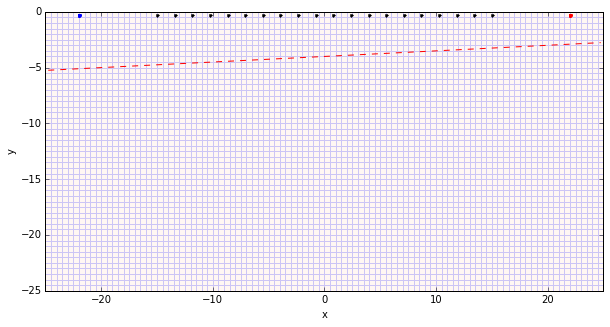

True

In [114]:
interact(viewInv, iteration = IntSlider(min=0, max=opt.iter-1,step=1, value=0))

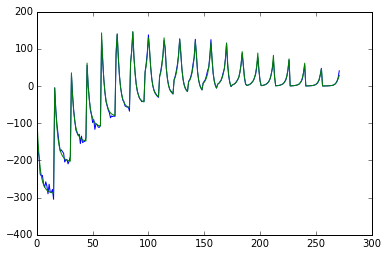

In [46]:
plt.plot(survey.dobs)
plt.plot(invProb.dpred)